# Dimensionality Reduction

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.axes import Axes
from scipy.spatial.transform import Rotation
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.datasets import fetch_openml, make_swiss_roll
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import Bunch
from sklearn.random_projection import johnson_lindenstrauss_min_dim, GaussianRandomProjection, SparseRandomProjection
from sklearn.manifold import LocallyLinearEmbedding, MDS, Isomap, TSNE
from sklearn.base import BaseEstimator

## Generating Dataset

In [44]:
m: int = 60
# initialize 3D dataset
X: np.ndarray = np.zeros((m, 3))

np.random.seed(42)
# uneven distribution
angles: np.ndarray = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi    # multiplying by 2 * np.pi converts the values to angles in radians
# oval
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5    # using sin and cos on angles to make ovals
# add more noise
X += 0.28 * np.random.randn(m, 3)  
# rotation
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]     # dataset is shifted along the x and z axes by 0.2 units

In [45]:
X[:5]

array([[-0.47562927, -1.18002627, -0.18665138],
       [-0.32908278,  0.18101846, -0.32767249],
       [ 1.1241412 ,  0.33792292,  0.15481443],
       [ 0.28072425, -0.21472162,  0.43963185],
       [-0.59903727, -0.94120105,  0.06412454]])

## PCA

In [46]:
X_centered: np.ndarray = X - X.mean(axis= 0)
X_centered[:5]

array([[-0.37234673, -0.80003737, -0.27221101],
       [-0.22580025,  0.56100735, -0.41323212],
       [ 1.22742374,  0.71791181,  0.0692548 ],
       [ 0.38400679,  0.16526728,  0.35407222],
       [-0.49575473, -0.56121216, -0.02143509]])

In [47]:
U, S, Vt = np.linalg.svd(X_centered)

In [48]:
Vt

array([[ 0.67857588,  0.70073508,  0.22023881],
       [-0.72817329,  0.6811147 ,  0.07646185],
       [-0.09642839, -0.21225719,  0.97244458]])

We want to transform the data to 2D so we use the second eigen vector (Second PC).

In [49]:
b2: np.ndarray = Vt[:2].T
X2d: np.ndarray = X_centered @ b2

In [50]:
X2d[:5]

array([[-0.87323119, -0.29459803],
       [ 0.14888518,  0.51493557],
       [ 1.35121872, -0.39950155],
       [ 0.45436676, -0.1399845 ],
       [-0.73438909, -0.02289346]])

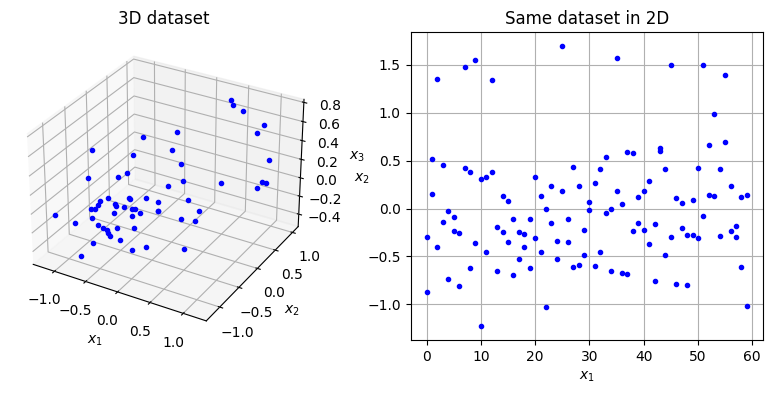

In [53]:
plt.figure(figsize= (10, 4))

ax: Axes = plt.subplot(121, projection= '3d')
ax.plot(X[:, 0], X[:, 1], X[:, 2], 'b.')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
ax.set_title('3D dataset')
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)

ax = plt.subplot(122)
ax.plot(X2d, 'b.')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$', rotation= 0)
ax.set_title('Same dataset in 2D')
ax.grid()

plt.show()

## Using Scikit-Learn

In [10]:
pca = PCA(n_components= 2)
X2d= pca.fit_transform(X)

In [11]:
X2d[:5]

array([[-0.87323119,  0.29459803],
       [ 0.14888518, -0.51493557],
       [ 1.35121872,  0.39950155],
       [ 0.45436676,  0.1399845 ],
       [-0.73438909,  0.02289346]])

In [12]:
pca.components_   # principle components

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

In [13]:
pca.explained_variance_ratio_   # indicates the proportions of dataset's variance that lies along each principal component

array([0.7578477 , 0.15186921])

In [14]:
1 - pca.explained_variance_ratio_.sum()

0.09028309326742034

This means we lost 9% of variance

## Choosing the Right Number of Dimensions

In [15]:
mnist: Bunch = fetch_openml('mnist_784', as_frame= False, parser= 'auto')
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

In [16]:
pca = PCA(n_components= 0.95)
X_reduced = pca.fit_transform(X_train)

In [17]:
pca.n_components_

154

## Fine - Tuning

In [18]:
clf: Pipeline = make_pipeline(
    PCA(random_state= 42),
    RandomForestClassifier(n_jobs= -1, random_state= 42)
)

In [19]:
param_dist: dict[str, np.ndarray] = {
    'pca__n_components': np.arange(10, 80),
    'randomforestclassifier__n_estimators': np.arange(50, 500)
}

rnd_search_cv = RandomizedSearchCV(
    estimator= clf,
    param_distributions= param_dist,
    cv= 3, 
    random_state= 42
)

rnd_search_cv.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [20]:
rnd_search_cv.best_params_

{'randomforestclassifier__n_estimators': 465, 'pca__n_components': 23}

## PCA for compression

In [21]:
X_recovered = pca.inverse_transform(X_reduced)

## Randomized PCA

In [22]:
rnd_pca = PCA(n_components= 154, svd_solver= 'randomized', random_state= 42)
X_reduces = rnd_pca.fit_transform(X_train)

## Incremental PCA

In [23]:
ipca = IncrementalPCA(n_components= 154)
n_batches: int = 100
    
for X_batch in np.array_split(X_train, n_batches):
    ipca.partial_fit(X_batch)

### Using Memory Map

In [24]:
X_mmap = np.memmap('mnist.mmap', dtype= 'int64', mode= 'write', shape= (60000, 784))
X_mmap[:] = X_train
X_mmap.flush()

In [25]:
X_mmap = np.memmap('mnist.mmap', dtype= 'int64', mode= 'readonly', shape= (60000, 784))

In [26]:
batch_size = X_mmap.shape[0] // n_batches

ipca = IncrementalPCA(n_components= 154, batch_size= batch_size)
ipca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)

## Random Projection

In [27]:
m: int = 5_000
epsilon: float = 0.1

d: int = johnson_lindenstrauss_min_dim(m, eps= epsilon)   # eps = 0.1 (10%) default
d

7300

In [28]:
d = int(4 * np.log(m) / (epsilon ** 2 / 2 - epsilon ** 3 / 3))    # formula
d

7300

In [29]:
n: int = 20_000
    
np.random.seed(42)
projection_matrix: np.ndarray = np.random.randn(d, n) / np.sqrt(d)   # std = sqrt(variance)

X: np.ndarray = np.random.randn(m, n)
X_reduced: np.ndarray = X @ projection_matrix.T

In [30]:
X_reduced[0]

array([ 0.65601016, -1.52157349, -2.13016582, ..., -3.30298058,
        1.86509223, -0.62205374])

In [31]:
gaussian_rnd_projection = GaussianRandomProjection(random_state= 42)
X_reduced = gaussian_rnd_projection.fit_transform(X)

In [32]:
X_reduced[0]

array([ 0.65601016, -1.52157349, -2.13016582, ..., -3.30298058,
        1.86509223, -0.62205374])

In [33]:
gaussian_rnd_projection.components_

array([[ 5.81359943e-03, -1.61826124e-03,  7.58062095e-03, ...,
         4.42829826e-03,  2.00553485e-02, -1.89597272e-02],
       [ 4.07638220e-03,  3.31605183e-03, -1.09611357e-02, ...,
         7.21559891e-03,  9.53444696e-03,  4.16636507e-03],
       [-5.52267488e-03,  1.18527859e-02, -2.31960160e-03, ...,
         1.65039881e-03, -2.55380604e-02, -7.48780800e-05],
       ...,
       [-1.03564530e-02,  7.94509570e-03, -5.69474166e-03, ...,
         1.14580829e-02, -1.29950377e-02, -1.59301221e-02],
       [-6.77138686e-03, -5.90454856e-03,  1.23942811e-02, ...,
        -2.01775486e-02, -1.75452980e-03, -7.52724235e-03],
       [-4.12988138e-03,  1.24015654e-02,  3.58943880e-04, ...,
        -6.18872802e-03,  5.77292951e-04,  6.83212442e-03]])

In [34]:
pinv_components: np.ndarray = np.linalg.pinv(gaussian_rnd_projection.components_)
X_recovered: np.ndarray = X_reduced @ pinv_components.T

In [35]:
print('GaussianRandomProjection fit')
%timeit GaussianRandomProjection(random_state=42).fit(X)
print('SparseRandomProjection fit')
%timeit SparseRandomProjection(random_state=42).fit(X)

gaussian_rnd_proj = GaussianRandomProjection(random_state=42).fit(X)
sparse_rnd_proj = SparseRandomProjection(random_state=42).fit(X)
print('GaussianRandomProjection transform')
%timeit gaussian_rnd_proj.transform(X)
print('SparseRandomProjection transform')
%timeit sparse_rnd_proj.transform(X)

GaussianRandomProjection fit
4.71 s ± 25.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection fit
6.69 s ± 33.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
GaussianRandomProjection transform
22.5 s ± 394 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection transform
5.7 s ± 34.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


we can see transform in sparse random projection is faster, and it also takes less memory.

## Locally Linear Embedding (LLE)

In [38]:
X_swiss, t = make_swiss_roll(n_samples= 1000, noise= 0.2, random_state= 42)

In [39]:
lle = LocallyLinearEmbedding(n_neighbors= 10, n_jobs= -1, random_state= 42)
X_unrolled: np.ndarray = lle.fit_transform(X_swiss)

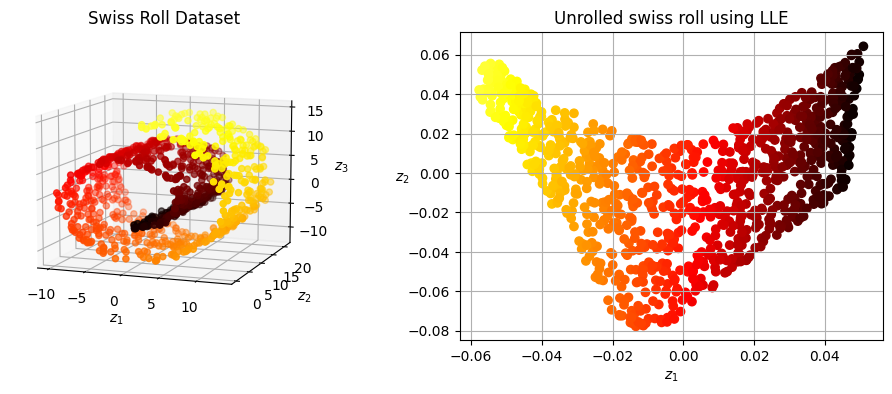

In [68]:
dark_to_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

plt.figure(figsize= (12, 4))

ax: Axes = plt.subplot(121, projection= '3d')
ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c= t, cmap= dark_to_hot)
ax.view_init(10, -70)
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.set_zlabel('$z_3$')
ax.set_title('Swiss Roll Dataset')
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)

ax = plt.subplot(122)
ax.scatter(X_unrolled[:, 0], X_unrolled[:, 1], c= t, cmap= dark_to_hot)
ax.grid()
ax.set_title('Unrolled swiss roll using LLE')
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$', rotation= 0)

plt.show()

## Other Dimensionality Reduction Techniques

In [84]:
mds = MDS(normalized_stress= False, n_jobs= -1, random_state= 42)
isomap = Isomap(n_jobs= -1)
tnse = TSNE(n_jobs= -1, random_state= 42)
linear_kernel = KernelPCA(n_jobs= -1, random_state= 42)
rbf_kernel = KernelPCA(kernel= 'rbf', gamma= 0.002, n_jobs= -1, random_state= 42)
poly_kernel = KernelPCA(kernel= 'poly', n_jobs= -1, random_state= 42)

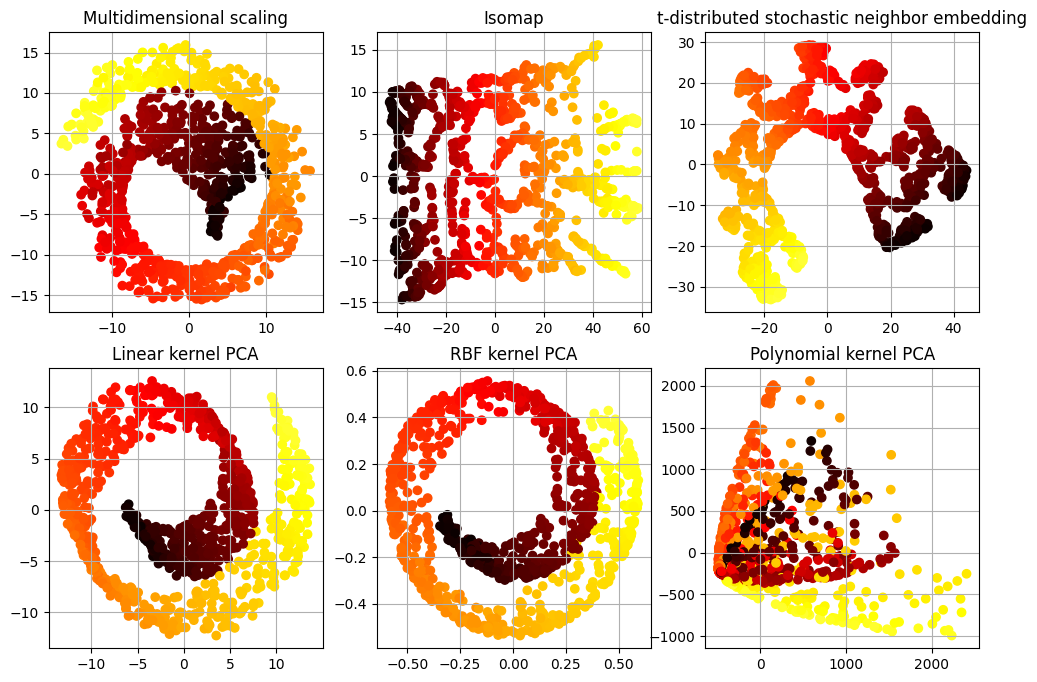

In [85]:
models: list[BaseEstimator] = [mds, isomap, tnse, linear_kernel, rbf_kernel, poly_kernel]
titles: list[str] = [
    'Multidimensional scaling',
    'Isomap',
    't-distributed stochastic neighbor embedding',
    'Linear kernel PCA',
    'RBF kernel PCA',
    'Polynomial kernel PCA'
]
    
plt.figure(figsize= (12, 8))

for model, subplot, title in zip(models, range(231, 237), titles):
    ax: Axes = plt.subplot(subplot)
    X_unrolled: np.ndarray = model.fit_transform(X_swiss)
    ax.scatter(X_unrolled[:, 0], X_unrolled[:, 1], c= t, cmap= dark_to_hot)
    ax.grid()
    ax.set_title(title)
    
plt.show()